In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from skimage.feature import hog
plt.close()

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], nbins, bins_range)
    ghist = np.histogram(img[:,:,1], nbins, bins_range)
    bhist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(img, conv='YCrCb'):
    # apply color conversion if other than 'RGB'
    if conv != 'RGB':
        if conv == 'HSV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: cimage = np.copy(img)   
    return cimage

def plot_samples(image, spatial_features, rh, gh, bh, bincen, hog_image):
    # Plot the examples
    # Plot features
    plt.figure()
    plt.plot(spatial_features)
    plt.title('Spatially Binned Features')
    # Plot a figure with all three bar charts
    if rh is not None:
        plt.figure()
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
    # Plot the examples
    plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')    
    plt.show()
            
            
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print('training image count: ', len(imgs))
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
        # Apply bin_spatial() to get spatial color features
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        # Apply color_hist() also with a color space option now
        rh, gh, bh, bincen, hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if vis:
            if hog_channel is not 'ALL':
                hog_feature, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         print('spacial: ', spatial_features.shape)
#         print('hist: ', hist_features.shape)
#         print('hog:', hog_features.shape)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        if vis:
            print("Plot image samples")
            plot_samples(image, spatial_features, rh, gh, bh, bincen, hog_image)
    # Return list of feature vectors
    return features

def fit_scale(data):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(data).astype(np.float64) 
    print(np.amin(X))
    print(np.amax(X))
#     print(X.shape)
    # Fit a per-column scaler
    return StandardScaler().fit(X)
    
## Data is a tuple of data
def scale_data(X_scaler, data):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(data).astype(np.float64) 
    # Apply the scaler to X
#     print(X.shape)
    return X_scaler.transform(X)

def testdata():
    cars = []
    cars.append(glob.glob('test_images/image*.png'))

    car_features = extract_features(cars[0], cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=0, vis=True)

def load_data():
    # Read in car and non-car images
    cars = glob.glob('training/vehicles/*/*.png')
    notcars = glob.glob('training/non-vehicles/*/*.png')
    return cars, notcars

HYPERPARAMS = {
    'COLOR_SPACE': 'YUV', # Color space
    'SPATIAL_FEAT': True, # Using spacial features?
    'SPATIAL_SIZE': (32, 32), # How many spacial features
    'HOG_FEAT': True, # Using hog features?
    'HOG_ORIENT': 9, # Hog cell orientation
    'HOG_PIX_PER_CELL': 8, # Pixels per hog cell
    'HOG_CELL_PER_BLOCK': 2, # Hog cell overlap
    'HOG_CHANNEL': "ALL",  # Which hog channels to use
    'HIST_FEAT': True, # Using histogram features?
    'HIST_RANGE': (0.0, 256.0), # Histogram min / max
    'HIST_BIN': 32, # How many bins for histogram
    'HEAT_THRESHOLD': 2.0, # Threshold to reject false positives
    'HEAT_FRAMES': 5 # Over how many frames to collect heat
}


training image count:  1
Plot image samples


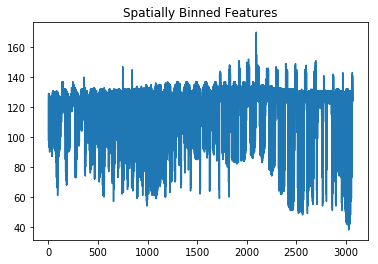

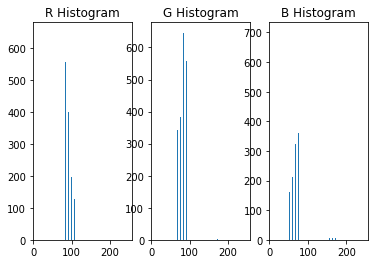

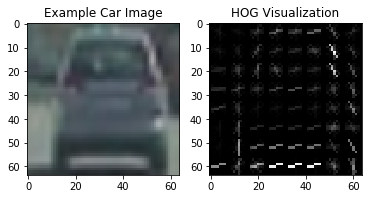

In [5]:
testdata()

In [3]:

def train_model():
    #Load data
    cars, notcars = load_data()

    # TODO play with these values to see how your classifier
    # performs under different binning scenarios

    car_features = extract_features(cars, cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=HYPERPARAMS['HOG_CHANNEL'], vis=False)
    notcar_features = extract_features(notcars, cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=HYPERPARAMS['HOG_CHANNEL'], vis=False)
#     print(np.vstack(car_features).astype(np.float64).shape )
    # Apply the scaler to X
    print(len(car_features))
    data = (car_features, notcar_features)
    x_scaler = fit_scale(data)
    scaled_X = scale_data(x_scaler, data)
    
    print(np.amin(scaled_X))
    print(np.amax(scaled_X))
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',HYPERPARAMS['SPATIAL_SIZE'],
        'and', HYPERPARAMS['HIST_BIN'],'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    joblib.dump(svc, 'vehicle-detection-model.pkl') 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 30
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return x_scaler, svc
    
    ## WE should save the model here somewhere so it can be reloaded once we've trained it.

In [ ]:
## Train the model, and then return the classifier used for predictionx
x_scaler, svc = train_model()


training image count:  8792
training image count:  8968


In [ ]:
def add_heat(heatmap, bbox_list, threshold):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    for box in bbox_list:
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > threshold:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += (threshold + 1)
    
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
      
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    #Only use the image within the ystart and ystop positions
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    n_box = 0
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             print('hog_features: ', hog_features.shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins, bins_range=(0,256))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                n_box+=1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                bbox_list.append(box)
#                 cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                
    print('Number of boxes found: ', n_box)
    return draw_img, bbox_list

def heat_map(img, bbox_list, heat_thresh=1):
    print("iterations: ",iteration)
    global iteration, heatmaps
    if len(bbox_list) > 0:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,bbox_list, heat_thresh)

        heatmaps.append(heat)
        print('heatmap len: ', len(heatmaps))
        
        # average heats
        avg_heat = sum(heatmaps)/len(heatmaps)
        heat = avg_heat
        heat = apply_threshold(heat,heat_thresh)
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    else:
        # pass the image itself if nothing was detected
        draw_img = np.copy(img)
    iteration += 1

    fig = plt.figure()
    plt.figure()
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.figure()
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.show()
    return draw_img


In [ ]:
from collections import deque
svc = joblib.load('vehicle-detection-model.pkl') 
heatmaps = deque(maxlen=10)
iteration = 1

def process_image(img):
    draw_image = np.copy(img)
    bbox = []
    bbox1 = []
    bbox2 = []
    bbox3 = []
    bbox4 = []
    
    ystart = 390
    ystop = 600
    scale = 1
    found_img, bbox0 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
                                HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
                                HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
                                HYPERPARAMS['HIST_BIN'])
    
#     ystart = 460
#     ystop = 585
#     scale = 1.5
#     found_img, bbox1 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
#                                 HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
#                                 HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
#                                 HYPERPARAMS['HIST_BIN'])
    
#     ystart = 500
#     ystop = 580
#     scale = 2
#     found_img, bbox2 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
#                                 HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
#                                 HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
#                                 HYPERPARAMS['HIST_BIN'])
    
#     ystart = 500
#     ystop = img.shape[0]
#     scale = 2.5
#     found_img, bbox3 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
#                                 HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
#                                 HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
#                                 HYPERPARAMS['HIST_BIN'])

    
    bbox = bbox0
    
    for box in bbox0:
        cv2.rectangle(found_img,box[0],box[1],(255,0,255),6) 
    
#     for box in bbox1:
#         cv2.rectangle(found_img,box[0],box[1],(0,0,255),6) 
    
#     for box in bbox2:
#         cv2.rectangle(found_img,box[0],box[1],(0,100,100),6) 
    
#     for box in bbox3:
#         cv2.rectangle(found_img,box[0],box[1],(100,100,100),6) 
    
    
    out_img = heat_map(found_img, bbox, 1)
    return out_img

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test8.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

plt.close()
# plt.figure()
# plt.imshow(out_img)
# plt.show()


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'output_images/project_output.mp4'
heatmaps.clear()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(27,29)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)